# Custom TransferLearning using DenseNet121

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import DenseNet121

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de los datos para el entrenamiento

In [3]:
img_size = 224
batch_size = 4
path_train = 'data_224/train'
path_test_validation = 'data_224/validation'

In [4]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    path_train,
    target_size=(img_size, img_size),
    batch_size=batch_size)

val_generator = datagen_val.flow_from_directory(
    path_test_validation,
    target_size=(img_size, img_size),
    batch_size=batch_size)

Found 12000 images belonging to 5 classes.
Found 1515 images belonging to 5 classes.


## Mostrando los labels que van a ser entrenados

In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

labels = '\n'.join(sorted(train_generator.class_indices.keys()))
print(labels)

10
100
20
200
50


In [6]:
# numero de clases a entrenar
num_classes = len(train_generator.class_indices.keys())

In [8]:
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

29089792/29084464 [==============================] - 4s 0us/step


In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# Empezando el entrenamiento

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

In [12]:
model = tf.keras.Sequential([
  base_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(num_classes, activation='softmax')
])

## Compilamos el modelo

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #default learning_rate = 0.001
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [15]:
epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator)

Epoch 1/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.2267 - accuracy: 0.9172 - val_loss: 3.9515 - val_accuracy: 0.3861
Epoch 2/10
3000/3000 [==============================] - 51s 17ms/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 2.9343 - val_accuracy: 0.4898
Epoch 3/10
3000/3000 [==============================] - 51s 17ms/step - loss: 0.0318 - accuracy: 0.9903 - val_loss: 4.0514 - val_accuracy: 0.5314
Epoch 4/10
3000/3000 [==============================] - 52s 17ms/step - loss: 0.0261 - accuracy: 0.9925 - val_loss: 7.0489 - val_accuracy: 0.3578
Epoch 5/10
3000/3000 [==============================] - 52s 17ms/step - loss: 0.0167 - accuracy: 0.9955 - val_loss: 5.0274 - val_accuracy: 0.5347
Epoch 6/10
3000/3000 [==============================] - 51s 17ms/step - loss: 0.0232 - accuracy: 0.9946 - val_loss: 3.3714 - val_accuracy: 0.5881
Epoch 7/10
3000/3000 [==============================] - 51s 17ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 4.2125 -

## Creando un gráfico para la revisión

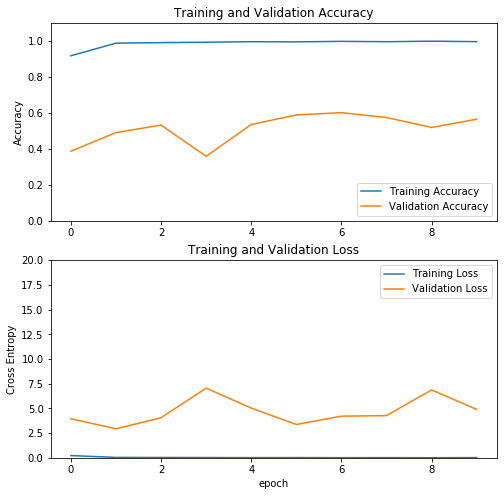

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Guardando el modelo

In [19]:
saved_model_dir = 'model_DenseNet121'
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_DenseNet121/assets


## Convirtiendo el modelo en tensorflow lite para el uso en mobile

In [20]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

path_tensorflow_lite = 'model_tflite/model_DenseNet121.tflite'
with open(path_tensorflow_lite, 'wb') as f:
  f.write(tflite_model)

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


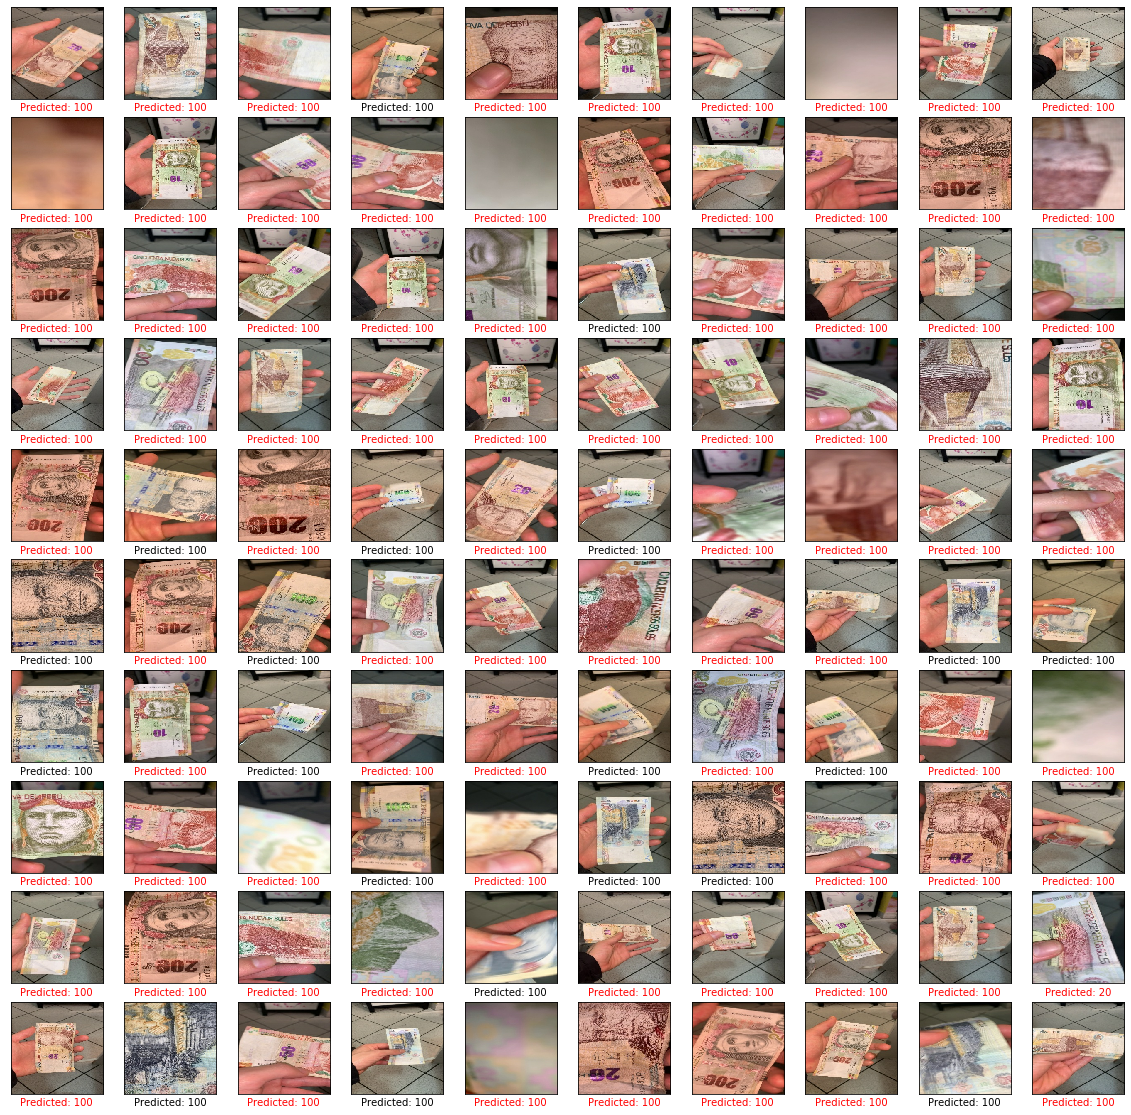

In [21]:
test_data = ImageClassifierDataLoader.from_folder(path_test_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()